In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

#### Load in Training Data.

### Extract Features for Difficulty Probe.

the features are created using Python scripts in the folder labeled "features" in the "scripts" subdirectory.

In [2]:
# df_train.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train_29000.csv", index=False)
# df_test.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_test_29000.csv", index=False)

# read in df_train, df_val, df_test.
df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/df_train_16000.csv")
df_test = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/df_test_16000.csv")
df_train.shape, df_test.shape

((191341, 10), (33842, 10))

In [3]:
df_train.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx
0,Given that the graph of the quadratic function...,2,0.600000,356,True,False,False,False,beam_search,6373
1,How many three-digit numbers are multiples of ...,2,0.000000,63,True,False,False,False,beam_search,7641
2,The line with equation \( y = 2x - 6 \) is ref...,2,0.566667,148,True,False,False,False,beam_search,13446
3,"Given fixed points \( A(3,0) \), \( B(0,4) \),...",2,0.000000,201,True,False,False,False,beam_search,5742
4,"In the lunch room, there were 14 chairs in the...",2,0.500000,291,True,False,False,False,beam_search,9545


In [4]:
df_test.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,0.433333,106,True,False,False,False,beam_search,10432
1,Jack and Rose want to start a dog-walking busi...,2,0.500000,229,True,False,False,False,beam_search,9858
2,Let $\mathbb{N}$ denote the set of all posit...,2,0.000000,379,True,False,False,False,beam_search,10298
3,For the function $f(x)$ which satisfies $f(2+x...,2,0.000000,177,True,False,False,False,beam_search,4845
4,"In a basketball game, Jon scored some points. ...",2,1.000000,210,True,False,False,False,beam_search,8693


### Load in Training/Testing Data

#### Make Predictions on Test.

16,000. BERT finetuned.

Average Train Loss: 0.5808
Average Val Loss: 0.6390

hidden-dim-3232-lr1e5-1-epoch

In [6]:
softLabel_preds_numpy = np.load('/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/numina16000-hidden-dim-32-16-lr1e4-1-epoch-pca-64/softLabel_preds.npy')

In [7]:
softLabel_preds_numpy.shape
y_val = df_test['sl']
df_test['predicted_prob'] = softLabel_preds_numpy

In [8]:
import matplotlib.pyplot as plt

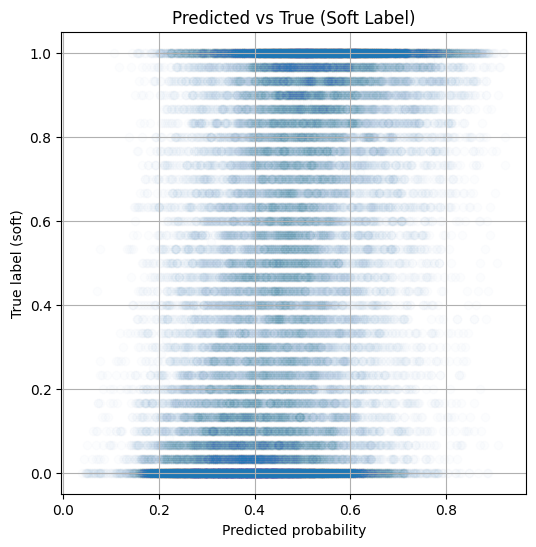

In [9]:
plt.figure(figsize=(6, 6)) # the probe is being conservative in predicting extreme values.
# look at targets for training.
# after every validation loss, plot a calibration chart... after each epoch...
plt.scatter(softLabel_preds_numpy, y_val, alpha=1e-2)
plt.xlabel("Predicted probability")
plt.ylabel("True label (soft)")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

/tmp/ipykernel_1835955/3001661611.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test.groupby("bin").agg(


bin
(0.04, 0.05]     7
(0.05, 0.06]     7
(0.06, 0.07]    11
(0.07, 0.08]    19
(0.08, 0.09]    11
                ..
(0.88, 0.89]    23
(0.89, 0.9]      9
(0.9, 0.91]      7
(0.91, 0.92]     3
(0.92, 0.93]     3
Name: count, Length: 89, dtype: int64


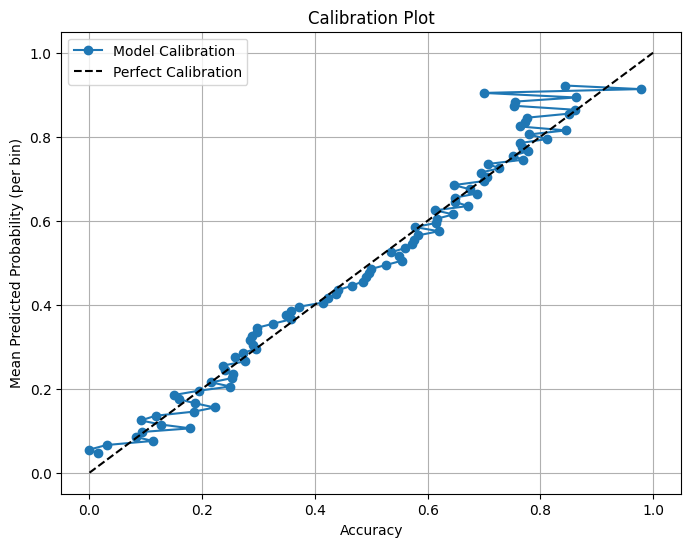

In [10]:
# calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 100
df_test["bin"] = pd.cut(df_test["predicted_prob"], bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test.groupby("bin").agg(
    avg_pred_prob=("predicted_prob", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()

AUC: 0.7030


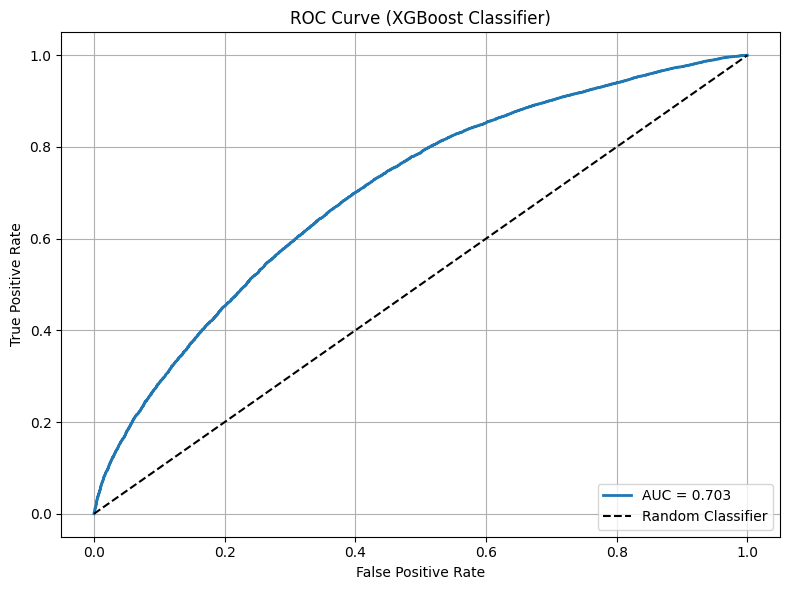

In [12]:
### Train XGBoost Classifier
y_test_binary = y_val > 0.5
from sklearn.metrics import roc_auc_score

# Compute AUC
auc = roc_auc_score(y_test_binary, softLabel_preds_numpy)
print(f"AUC: {auc:.4f}")
# AUC with all features.

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, softLabel_preds_numpy)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

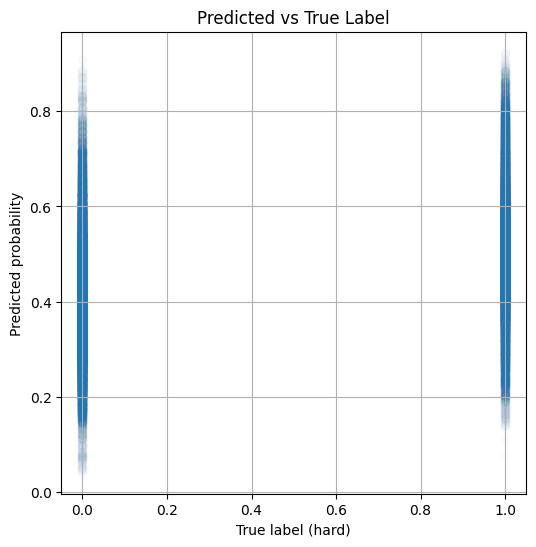

In [13]:
import matplotlib.pyplot as plt
# the XGBoost model does slightly better in outputting predicted probabilities.
plt.figure(figsize=(6, 6))
plt.scatter(y_test_binary, softLabel_preds_numpy, alpha=1e-2)
plt.xlabel("True label (hard)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True Label")
plt.grid(True)
plt.show()

In [15]:
# there should be 23 different BoN configurations for each query in the test set.
df_test.groupby('sb_idx').size().reset_index(name='count')

,sb_idx,count
0,2,15
1,7,14
2,17,15
3,25,15
4,35,14
...,...,...
2366,15786,14
2367,15795,12
2368,15797,12
2369,15798,15


Add token counts for parallel methods and for beam.

In [16]:
# created using concatenate_completions.py.
bon_token_counts = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/bon_token_counts_16000.csv')
bon_token_counts = bon_token_counts.rename(columns={"problem": "question"})
bon_token_counts.head()

,question,completion_tokens
0,Through the midpoint \(M\) of side \(BC\) of p...,"[456, 379, 547, 438, 475, 981, 397, 459, 590, ..."
1,Given $x=\log_{5}6\cdot\log_{6}7\cdot\log_{7}8...,"[513, 2048, 524, 614, 507, 545, 531, 575, 717,..."
2,"Let $a,$ $b,$ $c$ be positive real numbers suc...","[1285, 990, 883, 698, 749, 400, 877, 1020, 620..."
3,Given that the graph of the quadratic function...,"[1016, 731, 886, 1084, 828, 682, 822, 863, 837..."
4,"Three circles $\mathcal{K}_1$ , $\mathcal{K}...","[620, 629, 706, 678, 703, 573, 516, 641, 831, ..."


In [17]:
df_test = df_test.merge(bon_token_counts, on="question", how="left")
df_test.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,predicted_prob,bin,completion_tokens
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,0.433333,106,True,False,False,False,beam_search,10432,0.389685,"(0.38, 0.39]","[1285, 990, 883, 698, 749, 400, 877, 1020, 620..."
1,Jack and Rose want to start a dog-walking busi...,2,0.500000,229,True,False,False,False,beam_search,9858,0.680989,"(0.68, 0.69]","[16, 174, 166, 141, 158, 166, 16, 136, 150, 64..."
2,Let $\mathbb{N}$ denote the set of all posit...,2,0.000000,379,True,False,False,False,beam_search,10298,0.239241,"(0.23, 0.24]","[408, 997, 562, 1237, 1689, 724, 801, 1042, 10..."
3,For the function $f(x)$ which satisfies $f(2+x...,2,0.000000,177,True,False,False,False,beam_search,4845,0.369284,"(0.36, 0.37]","[305, 502, 526, 531, 455, 220, 470, 280, 389, ..."
4,"In a basketball game, Jon scored some points. ...",2,1.000000,210,True,False,False,False,beam_search,8693,0.581233,"(0.58, 0.59]","[247, 337, 281, 290, 314, 326, 289, 271, 305, ..."


Compute completion tokens.

In [18]:
# compute token counts.
# First turn completion tokens into a list of ints.
df_test["completion_tokens"] = df_test["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Then obtain Token Count for Best of N.
df_test["token_count"] = df_test.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)

In [19]:
print(df_test.groupby("N")["token_count"].describe())


     count         mean          std    min      25%     50%      75%      max
N                                                                             
2   9188.0  1109.917936   629.375405   12.0   651.75   977.0   1450.0   4096.0
4   9188.0  2205.212669  1175.524233   24.0  1347.00  1964.5   2895.0   7196.0
8   7678.0  4419.979422  2283.560023  166.0  2735.00  3974.0   5843.0  14687.0
16  8115.0  8840.119532  4514.760905  335.0  5477.50  7938.0  11671.5  28222.0


In [20]:
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = df_test.groupby(["N", "method"])[
    ["sl", "predicted_prob", "token_count"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()

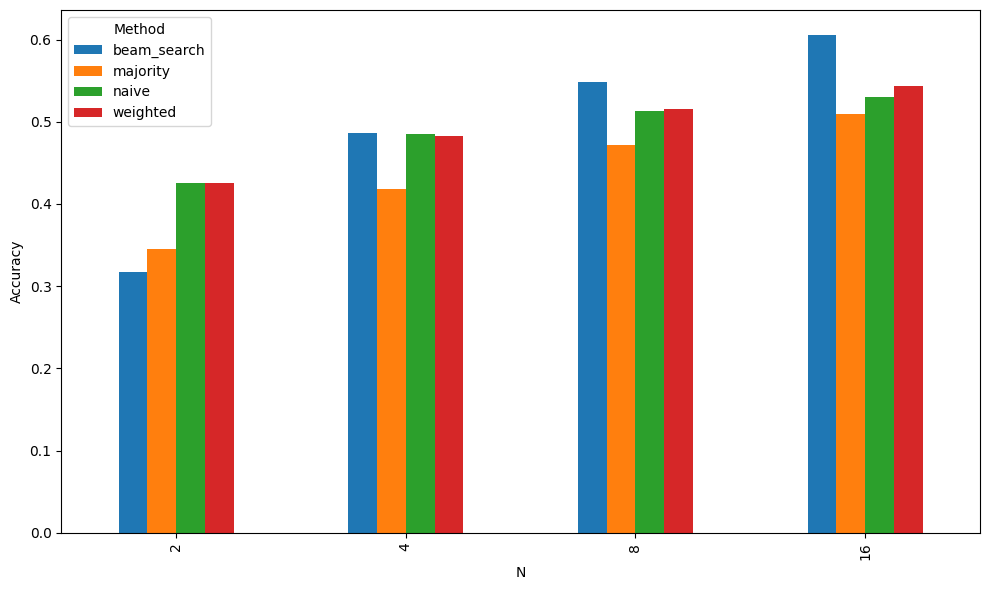

In [21]:
pivot_df = config_summary_df.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

# plt.title("Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

### Optimal-Utility Router

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

$$\text{Query-adaptive}(x, m) = \argmax_m \; \text{Utility}(x, m)

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.

In [28]:
def compute_max_utility_pred(df, lambda_):
    def get_max_utility(group): # verified correctness.
        group = group.copy()
        # if oracle == False:
        #     group["utility"] = group["predicted_prob"] - lambda_ * group["token_count"]
        # else:
        group["utility"] = group["predicted_prob"] - lambda_ * group["token_count"]
        idx_max = group["utility"].idxmax()
        # print("max utility index is: ", idx_max)
        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "predicted_prob"],
            "max_sl": group.loc[idx_max, "sl"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "token_count"],
            # "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "method": group.loc[idx_max, "method"],
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

#### When Lambda = 0.

In [29]:
# Sweep over lambda values
lambda_list = np.logspace(-50, -1, num=50) 

In [30]:
results_adaptive = []
results_oracle = []

for lambda_value in lambda_list:
    adaptive_router = compute_max_utility_pred(df_test, lambda_value)
    # oracle_router = compute_max_utility_pred(df_test, lambda_value)

    average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
    average_cost = adaptive_router["max_cost"].mean()
    average_predicted_prob = adaptive_router["max_predicted_prob"].mean()

    # oracle_accuracy = oracle_router["max_sl"].mean()
    # oracle_cost = oracle_router["max_cost"].mean()
    # oracle_predicted_prob = oracle_router["max_predicted_prob"].mean()

    results_adaptive.append({
        "lambda": lambda_value,
        "sl": average_accuracy,
        "token_count": average_cost,
        "predicted_prob": average_predicted_prob,
        # "time": average_time,
    })

    # results_oracle.append({
    #     "lambda": lambda_value,
    #     "sl": oracle_accuracy,
    #     "token_count": oracle_cost,
    #     "predicted_prob": oracle_predicted_prob,
    #     # "time": average_time,
    # })

# Convert to DataFrame
query_adaptive_df = pd.DataFrame(results_adaptive)
# query_oracle_df = pd.DataFrame(results_oracle)

/tmp/ipykernel_1835955/1094431755.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1835955/1094431755.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1835955/1094431755.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

In [31]:
query_adaptive_df["method"] = "adaptive"
query_adaptive_df.head()

,lambda,sl,token_count,predicted_prob,method
0,1.000000e-50,0.538591,8820.217208,0.551718,adaptive
1,1.000000e-49,0.538591,8820.217208,0.551718,adaptive
2,1.000000e-48,0.538591,8820.217208,0.551718,adaptive
3,1.000000e-47,0.538591,8820.217208,0.551718,adaptive
4,1.000000e-46,0.538591,8820.217208,0.551718,adaptive


In [35]:
query_oracle_df['method'] = 'oracle'
query_oracle_df.head()

,lambda,sl,token_count,predicted_prob,method
0,1.000000e-50,0.712512,4007.890763,0.455203,oracle
1,1.000000e-49,0.712512,4007.890763,0.455203,oracle
2,1.000000e-48,0.712512,4007.890763,0.455203,oracle
3,1.000000e-47,0.712512,4007.890763,0.455203,oracle
4,1.000000e-46,0.712512,4007.890763,0.455203,oracle


In [32]:
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
query_optimal_static_df = pd.merge(
    query_adaptive_df,
    config_summary_df,
    on=["sl", "token_count", "method", "predicted_prob"],
    how="outer"
)
query_optimal_static_df.head()
# change NaN to -1 for plotting purposes.
query_optimal_static_df = query_optimal_static_df.fillna(-1)

In [33]:
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,method,N
0,-1.000000e+00,0.317551,1109.085397,0.407219,beam_search,2.0
1,-1.000000e+00,0.344847,1110.146484,0.400977,majority,2.0
2,-1.000000e+00,0.418754,2206.691219,0.416412,majority,4.0
3,1.000000e-02,0.420842,1109.649515,0.455505,adaptive,-1.0
4,1.000000e-01,0.420842,1109.649515,0.455505,adaptive,-1.0
...,...,...,...,...,...,...
61,1.000000e-21,0.538591,8820.217208,0.551718,adaptive,-1.0
62,1.000000e-20,0.538591,8820.217208,0.551718,adaptive,-1.0
63,-1.000000e+00,0.542974,8839.693716,0.540519,weighted,16.0
64,-1.000000e+00,0.548259,4337.620469,0.449626,beam_search,8.0


Join the Oracle.

In [36]:
query_optimal_static_df = pd.merge(
    query_optimal_static_df,
    query_oracle_df,
    on=["lambda", "sl", "token_count", "predicted_prob", "method"],
    how="outer"
)

In [37]:
# Replace NaN values with -1 for plotting purposes
query_optimal_static_df = query_optimal_static_df.fillna(-1)

# Display the merged DataFrame
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,method,N
0,-1.000,0.317551,1109.085397,0.407219,beam_search,2.0
1,-1.000,0.344847,1110.146484,0.400977,majority,2.0
2,-1.000,0.418754,2206.691219,0.416412,majority,4.0
3,-1.000,0.425815,1110.146484,0.440776,weighted,2.0
4,-1.000,0.425815,1110.146484,0.442944,naive,2.0
...,...,...,...,...,...,...
111,0.001,0.502109,1118.248418,0.426387,oracle,-1.0
112,0.010,0.420842,1109.649515,0.455505,adaptive,-1.0
113,0.010,0.490215,1109.678617,0.426545,oracle,-1.0
114,0.100,0.420842,1109.649515,0.455505,adaptive,-1.0


In [38]:
# arrange in descending order of sl.
query_optimal_static_df.sort_values(by="sl", ascending=True)

,lambda,sl,token_count,predicted_prob,method,N
0,-1.000000e+00,0.317551,1109.085397,0.407219,beam_search,2.0
1,-1.000000e+00,0.344847,1110.146484,0.400977,majority,2.0
2,-1.000000e+00,0.418754,2206.691219,0.416412,majority,4.0
112,1.000000e-02,0.420842,1109.649515,0.455505,adaptive,-1.0
114,1.000000e-01,0.420842,1109.649515,0.455505,adaptive,-1.0
...,...,...,...,...,...,...
87,1.000000e-15,0.712512,3881.711092,0.453650,oracle,-1.0
43,1.000000e-37,0.712512,4007.890763,0.455203,oracle,-1.0
89,1.000000e-14,0.712512,3881.711092,0.453650,oracle,-1.0
67,1.000000e-25,0.712512,4007.890763,0.455203,oracle,-1.0


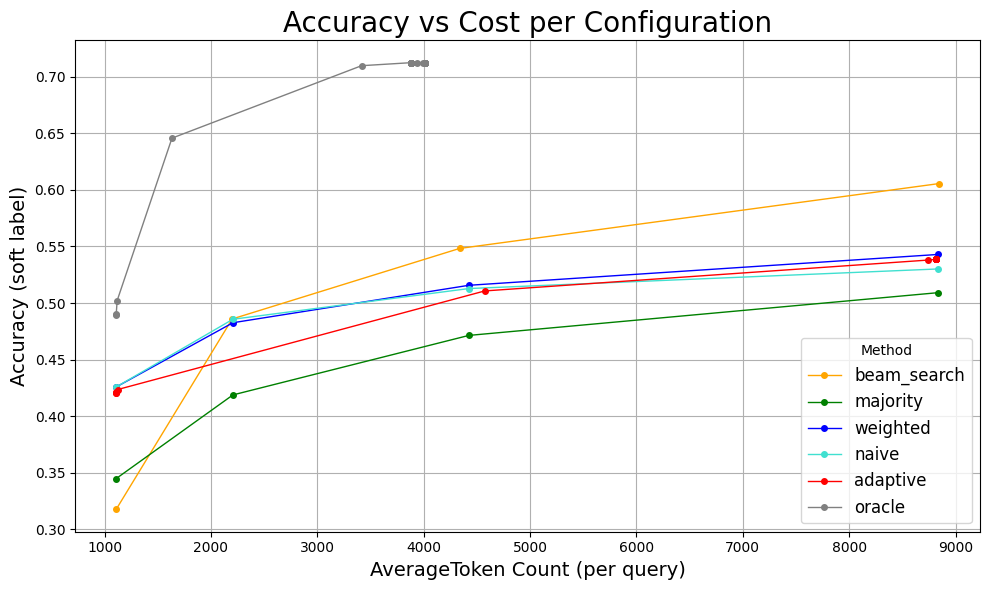

In [39]:
# Assign unique colors for each method
method_colors = {
    "majority": "green",
    "naive": "turquoise",
    "weighted": "blue",
    "beam_search": "orange",
    "adaptive": "red",  # Query-adaptive router
    "oracle": "gray"  # Oracle router
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("AverageToken Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

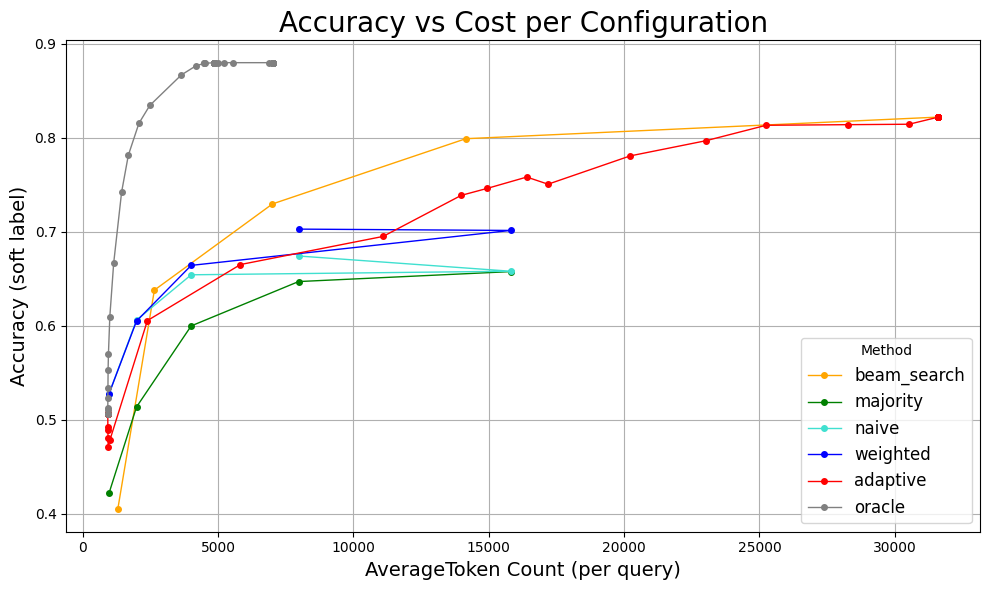

In [ ]:
# Assign unique colors for each method
method_colors = {
    "majority": "green",
    "naive": "turquoise",
    "weighted": "blue",
    "beam_search": "orange",
    "adaptive": "red",  # Query-adaptive router
    "oracle": "gray"  # Oracle router
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("AverageToken Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


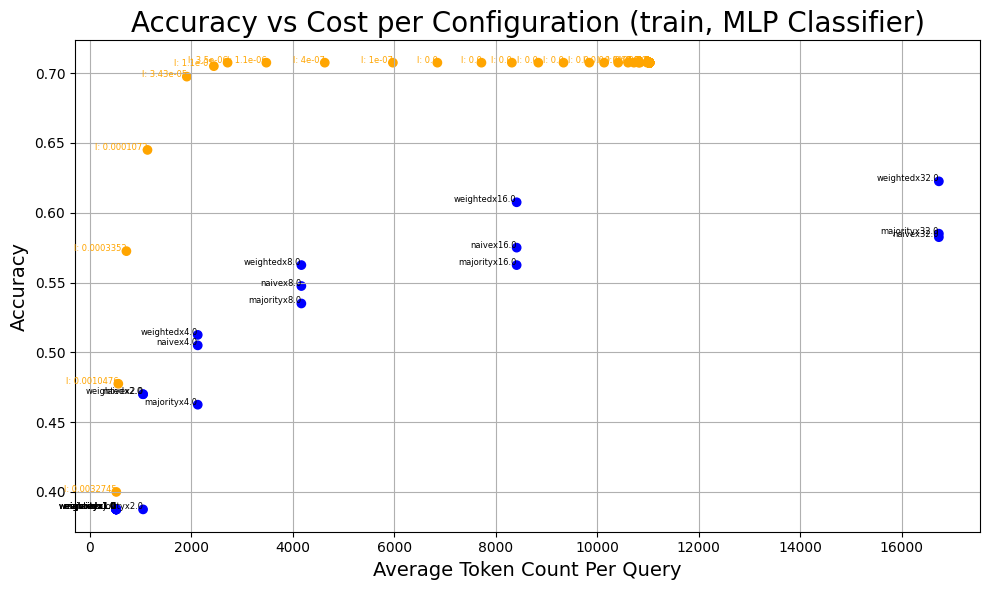

In [ ]:
# Create color labels and text labels (sklearn MLPClassifier)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, MLP Classifier)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'qa', 'qa', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'qa', 'weightedx8.0', 'majorityx16.0', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


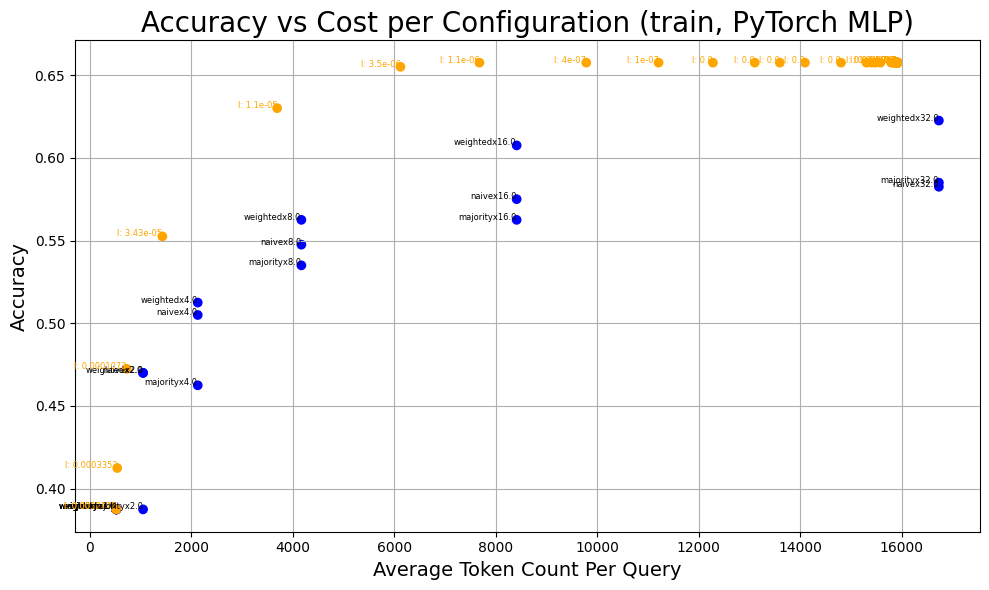

In [ ]:
# Create color labels and text labels (pyTorch MLP)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, PyTorch MLP)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


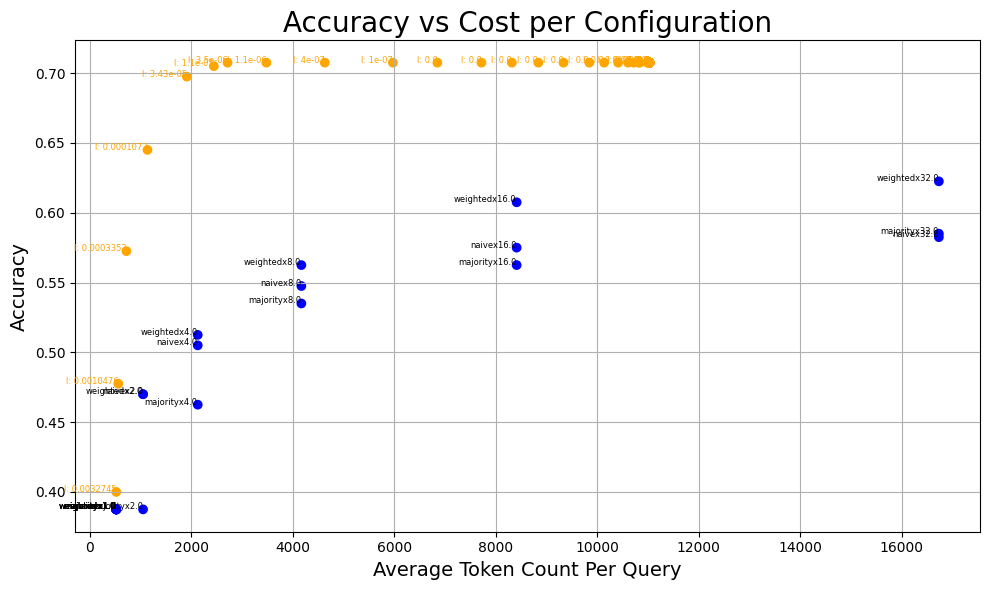

In [ ]:
# Create color labels and text labels
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

# plt.savefig("figs/accuracy_vs_cost_by_config3", dpi=300, bbox_inches='tight')

# notes: make sure we are plotting the accuracy. the probe should pick the weighted response.
# should not go below the blue dots. (check what you are actually plotting).